In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os

In [2]:
#Mounting on co-lab


from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/XD2Net_CaseStudy') # change folder name




Mounted at /content/drive


In [3]:
my_dir = "/content/drive/My Drive/XD2Net_CaseStudy"
log_file = my_dir+"/MIMICEL ANALYSIS/filtered_mimicel.csv" #the correct and most recent version

df = pd.read_csv(log_file)
df.head()

,stay_id,subject_id,hadm_id,timestamps,activity,gender,race,arrival_transport,disposition,seq_num,...,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn,los
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,spironolactone,6818.0,1.672902e+10,2.0,6043.0,Aldosterone Receptor Antagonists,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,spironolactone,6818.0,1.672902e+10,1.0,5658.0,"Diuretic - Aldosterone Receptor Antagonist, No...",NaN,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,rifaximin,66295.0,5.486862e+10,1.0,5844.0,Rifamycins and Related Derivative Antibiotics,NaN,NaN,NaN


In [4]:
df['timestamps'] = pd.to_datetime(df['timestamps'])
df['hour'] = df['timestamps'].dt.round("H")


#### Extraction of Static Features

Static Features can be extracted at the point of "Enter the ED" activity

In [62]:
df_static = df.loc[df['activity'] == 'Enter the ED'][['stay_id','gender','race','arrival_transport']]
df_static.head()

,stay_id,gender,race,arrival_transport
0,30000012,F,WHITE,AMBULANCE
22,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN
36,30000038,F,WHITE,AMBULANCE
54,30000039,M,WHITE,WALK IN
71,30000055,F,OTHER,WALK IN


In [63]:
df_static_2 = df.loc[df['activity'] == 'Triage in the ED'][['stay_id','pain','acuity','chiefcomplaint']]
df_static_2.head()

,stay_id,pain,acuity,chiefcomplaint
1,30000012,0,2.0,CHANGE IN MENTAL STATUS
23,30000017,0,3.0,"ETOH, Unable to ambulate"
37,30000038,0,3.0,Cough
55,30000039,0,3.0,s/p Fall
72,30000055,0,3.0,L Ear pain


In [64]:
df_static = df_static.merge(df_static_2, on = 'stay_id')
df_static.head()

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint
0,30000012,F,WHITE,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0,3.0,"ETOH, Unable to ambulate"
2,30000038,F,WHITE,AMBULANCE,0,3.0,Cough
3,30000039,M,WHITE,WALK IN,0,3.0,s/p Fall
4,30000055,F,OTHER,WALK IN,0,3.0,L Ear pain


#### Pain levels

In [65]:
pain_levels = df_static.groupby(['pain'])['stay_id'].size().reset_index().sort_values(by = 'stay_id',ascending = False).head(20)
pain_levels.head(20)

,pain,stay_id
108,0,140697
311,8,41727
162,10,40913
291,7,31419
254,5,29207
275,6,25203
337,9,20209
236,4,19721
218,3,16114
198,2,13902


In [66]:
pain_levels.iloc[:12]['stay_id'].sum()/df_static['stay_id'].nunique()

0.9315527447603452

for 93% of the cases the pain level is recorded using a numerical value.
So we remove the stay_ids with invalid pain levels from the dataset

In [67]:
df_static = df_static.merge(pain_levels.iloc[:12][['pain']], on = 'pain')
df_static['pain'] = df_static['pain'].astype(float)
len(df_static)

395936

In [68]:
df_static['pain'].unique()

array([ 0.,  2.,  9.,  3., 10.,  7.,  8.,  5.,  6., 13.,  1.,  4.])

### Extraction of information from the chief complaint - using topic modelling

In [69]:
# Load the regular expression library
import re
df_static['chiefcomplaint'] = df_static['chiefcomplaint'].astype(str)
# Remove punctuation
df_static['chiefcomplaint_processed'] = df_static['chiefcomplaint'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_static['chiefcomplaint_processed'] = df_static['chiefcomplaint_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_static['chiefcomplaint_processed'].head()

0    change in mental status
1    etoh unable to ambulate
2                      cough
3                   s/p fall
4                 l ear pain
Name: chiefcomplaint_processed, dtype: object

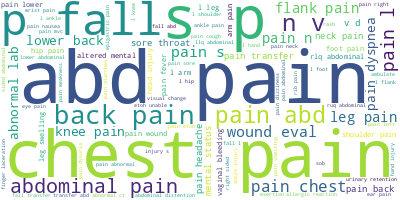

In [70]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_static['chiefcomplaint_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [71]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['/'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
df_static['chiefcomplaint_processed'] = df_static['chiefcomplaint_processed'].replace('abd','abdominal')
data = df_static['chiefcomplaint_processed'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['change', 'mental', 'status']


#### Manual topic modelling using medical context

Approach
* tokenize the chief complaint column into individual words
* Identify the top 100 keywords present in the chief complaint
* Segregate the keywords into different chief complain categories (supported by literature)
* Calculate the number of keywords in each category present in the each tokenized chief complaint. let `n` be the number of matching keywords in a given chief complaint, for a given chief complaint category.
* Then, `average(n/# of tokens in the chief complaint + n/# of keywords in the chief complaint category)` is calculated as the likelihood of that chief complaint belonging to that chief complaint category

In [72]:
words = []
for sent in data_words:
  words.extend(sent)

from collections import Counter

word_counts = Counter(words)
# Get the 100 most common terms
most_common_terms = word_counts.most_common(100)

key_words = [term for term, count in most_common_terms]


In [73]:
#Keyword based dictionaries

#highlevel category
cc_cat = {'General and Unspecified':['allergic','headache','fever','fall', 'headache', 'weakness', 'dizziness', 'swelling', 'cough', 'wound', 'throat', 'sore', 'bleeding','hypotension', 'lightheaded', 'abscess'],
'Blood and Immune':['anemia', 'tachycardia','dehydration'],
'Endocrine':['hyperglycemia','hypotension', 'presyncope','dehydration'],
'Respiratory':['dyspnea', 'dizziness', 'cough', 'throat'],
'Digestive':['pain','abd', 'abdominal','nausea', 'vomiting', 'constipation', 'rectal', 'diarrhea', 'brbpr','rlq', 'epigastric', 'ruq','llq','distention'],
'Urologic':['dysuria','urinary','hematuria','distention'],
'Eye/Ear/Skin':['eye', 'bleeding', 'rash','ear','pain'],
'Preganancy related':['bleeding',  'pregnant','hypertension'],
'Cardiovascular':['chest','pain', 'dizziness', 'palpitations', 'hypertension','dyspnea','syncope','hypotension', 'epigastric', 'presyncope', 'tachycardia', 'lightheaded'],
'Genital':['vaginal'],
'Musculoskeletal':['pain','lower','knee', 'laceration','foot','wound','shoulder','hip','hand','ankle','leg','injury','head', 'back', 'swelling','arm', 'sore','finger', 'bleeding', 'ambulate', 'wrist', 'fracture','toe'],
'Neurological':['head','dyspnea','syncope', 'numbness','seizure','hypotension'],
'Psychological':['depression','altered','mental','anxiety','confusion','dyspnea', 'dizziness', 'presyncope', 'tachycardia', 'lightheaded', 'psych','status']}


#special flags
cc_flag = {'Motor vehicle Collision':['mvc'],
'Suicide Ideation/ Self Injury':['si'],
'Assault':['assault'],
'Shortness of breath':['sob'],
'Substance presence':['etoh', 'substance'],
'Transfer':['transfer'],
'Status Post':['s/p']}

In [74]:
cc_cat_labels = ['General and Unspecified','Blood and Immune','Endocrine','Respiratory','Digestive','Urologic'
                ,'Eye/Ear/Skin','Preganancy related' ,'Cardiovascular','Genital','Musculoskeletal','Neurological','Psychological']

cc_flag_labels = ['Motor vehicle Collision','Suicide Ideation/ Self Injury','Assault','Shortness of breath','Substance presence','Transfer','Status Post']
chiefcomplaint_category = {'General and Unspecified':[],'Blood and Immune': [], 'Endocrine': [],'Respiratory': [],'Digestive': [],'Urologic': []
                ,'Eye/Ear/Skin': [],'Preganancy related': [] ,'Cardiovascular': [],'Genital': [],'Musculoskeletal': [],'Neurological': [],'Psychological': []}
chiefcomplaint_flag = {'Motor vehicle Collision':[],'Suicide Ideation/ Self Injury':[],'Assault':[],'Shortness of breath':[],'Substance presence':[],'Transfer':[],'Status Post':[]}

for i,word in enumerate(data_words):
  set_comp = set(word)

  cat_prob = 0.00000005
  final_category = 'Other'

  for cat in cc_cat_labels:
    set_comp_cat = set(cc_cat[cat])
    n = intersection_size = len(set_comp & set_comp_cat)
    cat_prob = (n/(len(set_comp)+1))
    chiefcomplaint_category[cat].append(cat_prob)


  for flag in cc_flag_labels:
    set_comp_flag = set(cc_flag[flag])
    n = intersection_size = len(set_comp & set_comp_flag)
    flag_prob = (n/(len(set_comp)+1))
    chiefcomplaint_flag[flag].append(flag_prob)









In [75]:
df_chiefcomplaint_cat = pd.DataFrame(chiefcomplaint_category)
df_chiefcomplaint_cat.head()

,General and Unspecified,Blood and Immune,Endocrine,Respiratory,Digestive,Urologic,Eye/Ear/Skin,Preganancy related,Cardiovascular,Genital,Musculoskeletal,Neurological,Psychological
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.250000,0.0,0.0
2,0.5,0.0,0.0,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.5,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.333333,0.0,0.666667,0.0,0.333333,0.0,0.333333,0.0,0.0


In [76]:
len(df_chiefcomplaint_cat)

395936

In [77]:
row_totals = df_chiefcomplaint_cat.sum(axis=1)  # Calculate the row totals

# Divide each row by its respective row total
df_chiefcomplaint_cat = df_chiefcomplaint_cat.div(row_totals, axis=0)
df_chiefcomplaint_cat.head()

,General and Unspecified,Blood and Immune,Endocrine,Respiratory,Digestive,Urologic,Eye/Ear/Skin,Preganancy related,Cardiovascular,Genital,Musculoskeletal,Neurological,Psychological
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.2,0.0,0.4,0.0,0.2,0.0,0.2,0.0,0.0


In [78]:
df_chiefcomplaint_flag = pd.DataFrame(chiefcomplaint_flag)
row_totals = df_chiefcomplaint_flag.sum(axis=1)  # Calculate the row totals

# Divide each row by its respective row total
df_chiefcomplaint_flag = df_chiefcomplaint_flag.div(row_totals, axis=0)
df_chiefcomplaint_flag = df_chiefcomplaint_flag.fillna(0)
df_chiefcomplaint_flag.head()

,Motor vehicle Collision,Suicide Ideation/ Self Injury,Assault,Shortness of breath,Substance presence,Transfer,Status Post
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
len(df_chiefcomplaint_flag)

395936

#### Merging the Chief complaint category with the static dataset

In [80]:
#Merging the df_t to df_static

df_static = df_static.join(df_chiefcomplaint_cat)
df_static = df_static.join(df_chiefcomplaint_flag)


In [81]:
df_static=df_static.fillna(0)
df_static.head(10)

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,General and Unspecified,Blood and Immune,...,Musculoskeletal,Neurological,Psychological,Motor vehicle Collision,Suicide Ideation/ Self Injury,Assault,Shortness of breath,Substance presence,Transfer,Status Post
0,30000012,F,WHITE,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,change in mental status,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0.0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,30000038,F,WHITE,AMBULANCE,0.0,3.0,Cough,cough,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000039,M,WHITE,WALK IN,0.0,3.0,s/p Fall,s/p fall,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000055,F,OTHER,WALK IN,0.0,3.0,L Ear pain,l ear pain,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,30000112,F,HISPANIC/LATINO - PUERTO RICAN,WALK IN,0.0,3.0,Abnormal labs,abnormal labs,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,30000252,F,WHITE,AMBULANCE,0.0,2.0,Anorexia,anorexia,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30000262,F,WHITE,AMBULANCE,0.0,3.0,"BRBPR, Constipation",brbpr constipation,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30000279,M,BLACK/AFRICAN AMERICAN,AMBULANCE,0.0,2.0,SI,si,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,30000291,M,WHITE,WALK IN,0.0,3.0,Epistaxis,epistaxis,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
len(df_static)

395936

In [83]:
df_static

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,General and Unspecified,Blood and Immune,...,Musculoskeletal,Neurological,Psychological,Motor vehicle Collision,Suicide Ideation/ Self Injury,Assault,Shortness of breath,Substance presence,Transfer,Status Post
0,30000012,F,WHITE,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,change in mental status,0.000000,0.0,...,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0.0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,0.000000,0.0,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,30000038,F,WHITE,AMBULANCE,0.0,3.0,Cough,cough,0.500000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000039,M,WHITE,WALK IN,0.0,3.0,s/p Fall,s/p fall,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000055,F,OTHER,WALK IN,0.0,3.0,L Ear pain,l ear pain,0.000000,0.0,...,0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395931,39995732,M,WHITE,WALK IN,4.0,4.0,R Finger pain,r finger pain,0.000000,0.0,...,0.400000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395932,39996600,M,WHITE,AMBULANCE,4.0,2.0,"Chest pain, Dyspnea, Transfer",chest pain dyspnea transfer,0.000000,0.0,...,0.111111,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0,1.0,0.0
395933,39998128,M,WHITE,WALK IN,4.0,3.0,"R Hand pain, R Hand swelling",r hand pain r hand swelling,0.142857,0.0,...,0.428571,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395934,39999466,F,AMERICAN INDIAN/ALASKA NATIVE,WALK IN,4.0,4.0,L Foot injury,l foot injury,0.000000,0.0,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
#Save the dataframe
df_static.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_static.csv", index = False)
#df_t.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_complaint_categories.csv", index = False)

### Analysis of the relationship between static featues and LOS

In [ ]:
df_static = pd.read_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_static.csv")
df_static.head()

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,chiefcomplaint_category,chiefcomplaint_flag
0,30000012,F,WHITE,AMBULANCE,0,2.0,CHANGE IN MENTAL STATUS,change in mental status,Psychological,NaN
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,Musculoskeletal,Substance presence
2,30000038,F,WHITE,AMBULANCE,0,3.0,Cough,cough,General and Unspecified,NaN
3,30000039,M,WHITE,WALK IN,0,3.0,s/p Fall,s/p fall,General and Unspecified,NaN
4,30000055,F,OTHER,WALK IN,0,3.0,L Ear pain,l ear pain,Eye/Ear/Skin,NaN


In [85]:
df_static.columns

Index(['stay_id', 'gender', 'race', 'arrival_transport', 'pain', 'acuity',
       'chiefcomplaint', 'chiefcomplaint_processed', 'General and Unspecified',
       'Blood and Immune', 'Endocrine', 'Respiratory', 'Digestive', 'Urologic',
       'Eye/Ear/Skin', 'Preganancy related', 'Cardiovascular', 'Genital',
       'Musculoskeletal', 'Neurological', 'Psychological',
       'Motor vehicle Collision', 'Suicide Ideation/ Self Injury', 'Assault',
       'Shortness of breath', 'Substance presence', 'Transfer', 'Status Post'],
      dtype='object')

In [86]:
df_static_encoded = df_static[['stay_id',	'pain', 'acuity','General and Unspecified',
       'Blood and Immune', 'Endocrine', 'Respiratory', 'Digestive', 'Urologic',
       'Eye/Ear/Skin', 'Preganancy related', 'Cardiovascular', 'Genital',
       'Musculoskeletal', 'Neurological', 'Psychological',
       'Motor vehicle Collision', 'Suicide Ideation/ Self Injury', 'Assault',
       'Shortness of breath', 'Substance presence', 'Transfer', 'Status Post']]
df_gender = pd.get_dummies(df_static['gender'])
df_race = pd.get_dummies(df_static['race'])
df_arrival = pd.get_dummies(df_static['arrival_transport'])


df_static_encoded = pd.concat([df_static_encoded,df_gender], axis = 1)
df_static_encoded = pd.concat([df_static_encoded,df_race], axis = 1)
df_static_encoded = pd.concat([df_static_encoded,df_arrival], axis = 1)

df_static_encoded.columns

Index(['stay_id', 'pain', 'acuity', 'General and Unspecified',
       'Blood and Immune', 'Endocrine', 'Respiratory', 'Digestive', 'Urologic',
       'Eye/Ear/Skin', 'Preganancy related', 'Cardiovascular', 'Genital',
       'Musculoskeletal', 'Neurological', 'Psychological',
       'Motor vehicle Collision', 'Suicide Ideation/ Self Injury', 'Assault',
       'Shortness of breath', 'Substance presence', 'Transfer', 'Status Post',
       'F', 'M', 'AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN',
       'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE', 'ASIAN - KOREAN',
       'ASIAN - SOUTH EAST ASIAN', 'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN',
       'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - COLUMBIAN',
       'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN',
       'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN',
     

In [87]:
df['activity'].unique()

array(['Enter the ED', 'Triage in the ED', 'Medicine reconciliation',
       'Vital sign check', 'Medicine dispensations',
       'Discharge from the ED'], dtype=object)

In [91]:
df_los = df.loc[ df['activity']== 'Discharge from the ED'][['stay_id','los']].drop_duplicates()
df_los = df_los.merge(df_static_encoded, on = 'stay_id' )


In [92]:
len(df_los)

395936

<ipython-input-93-91b944fb8dde>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


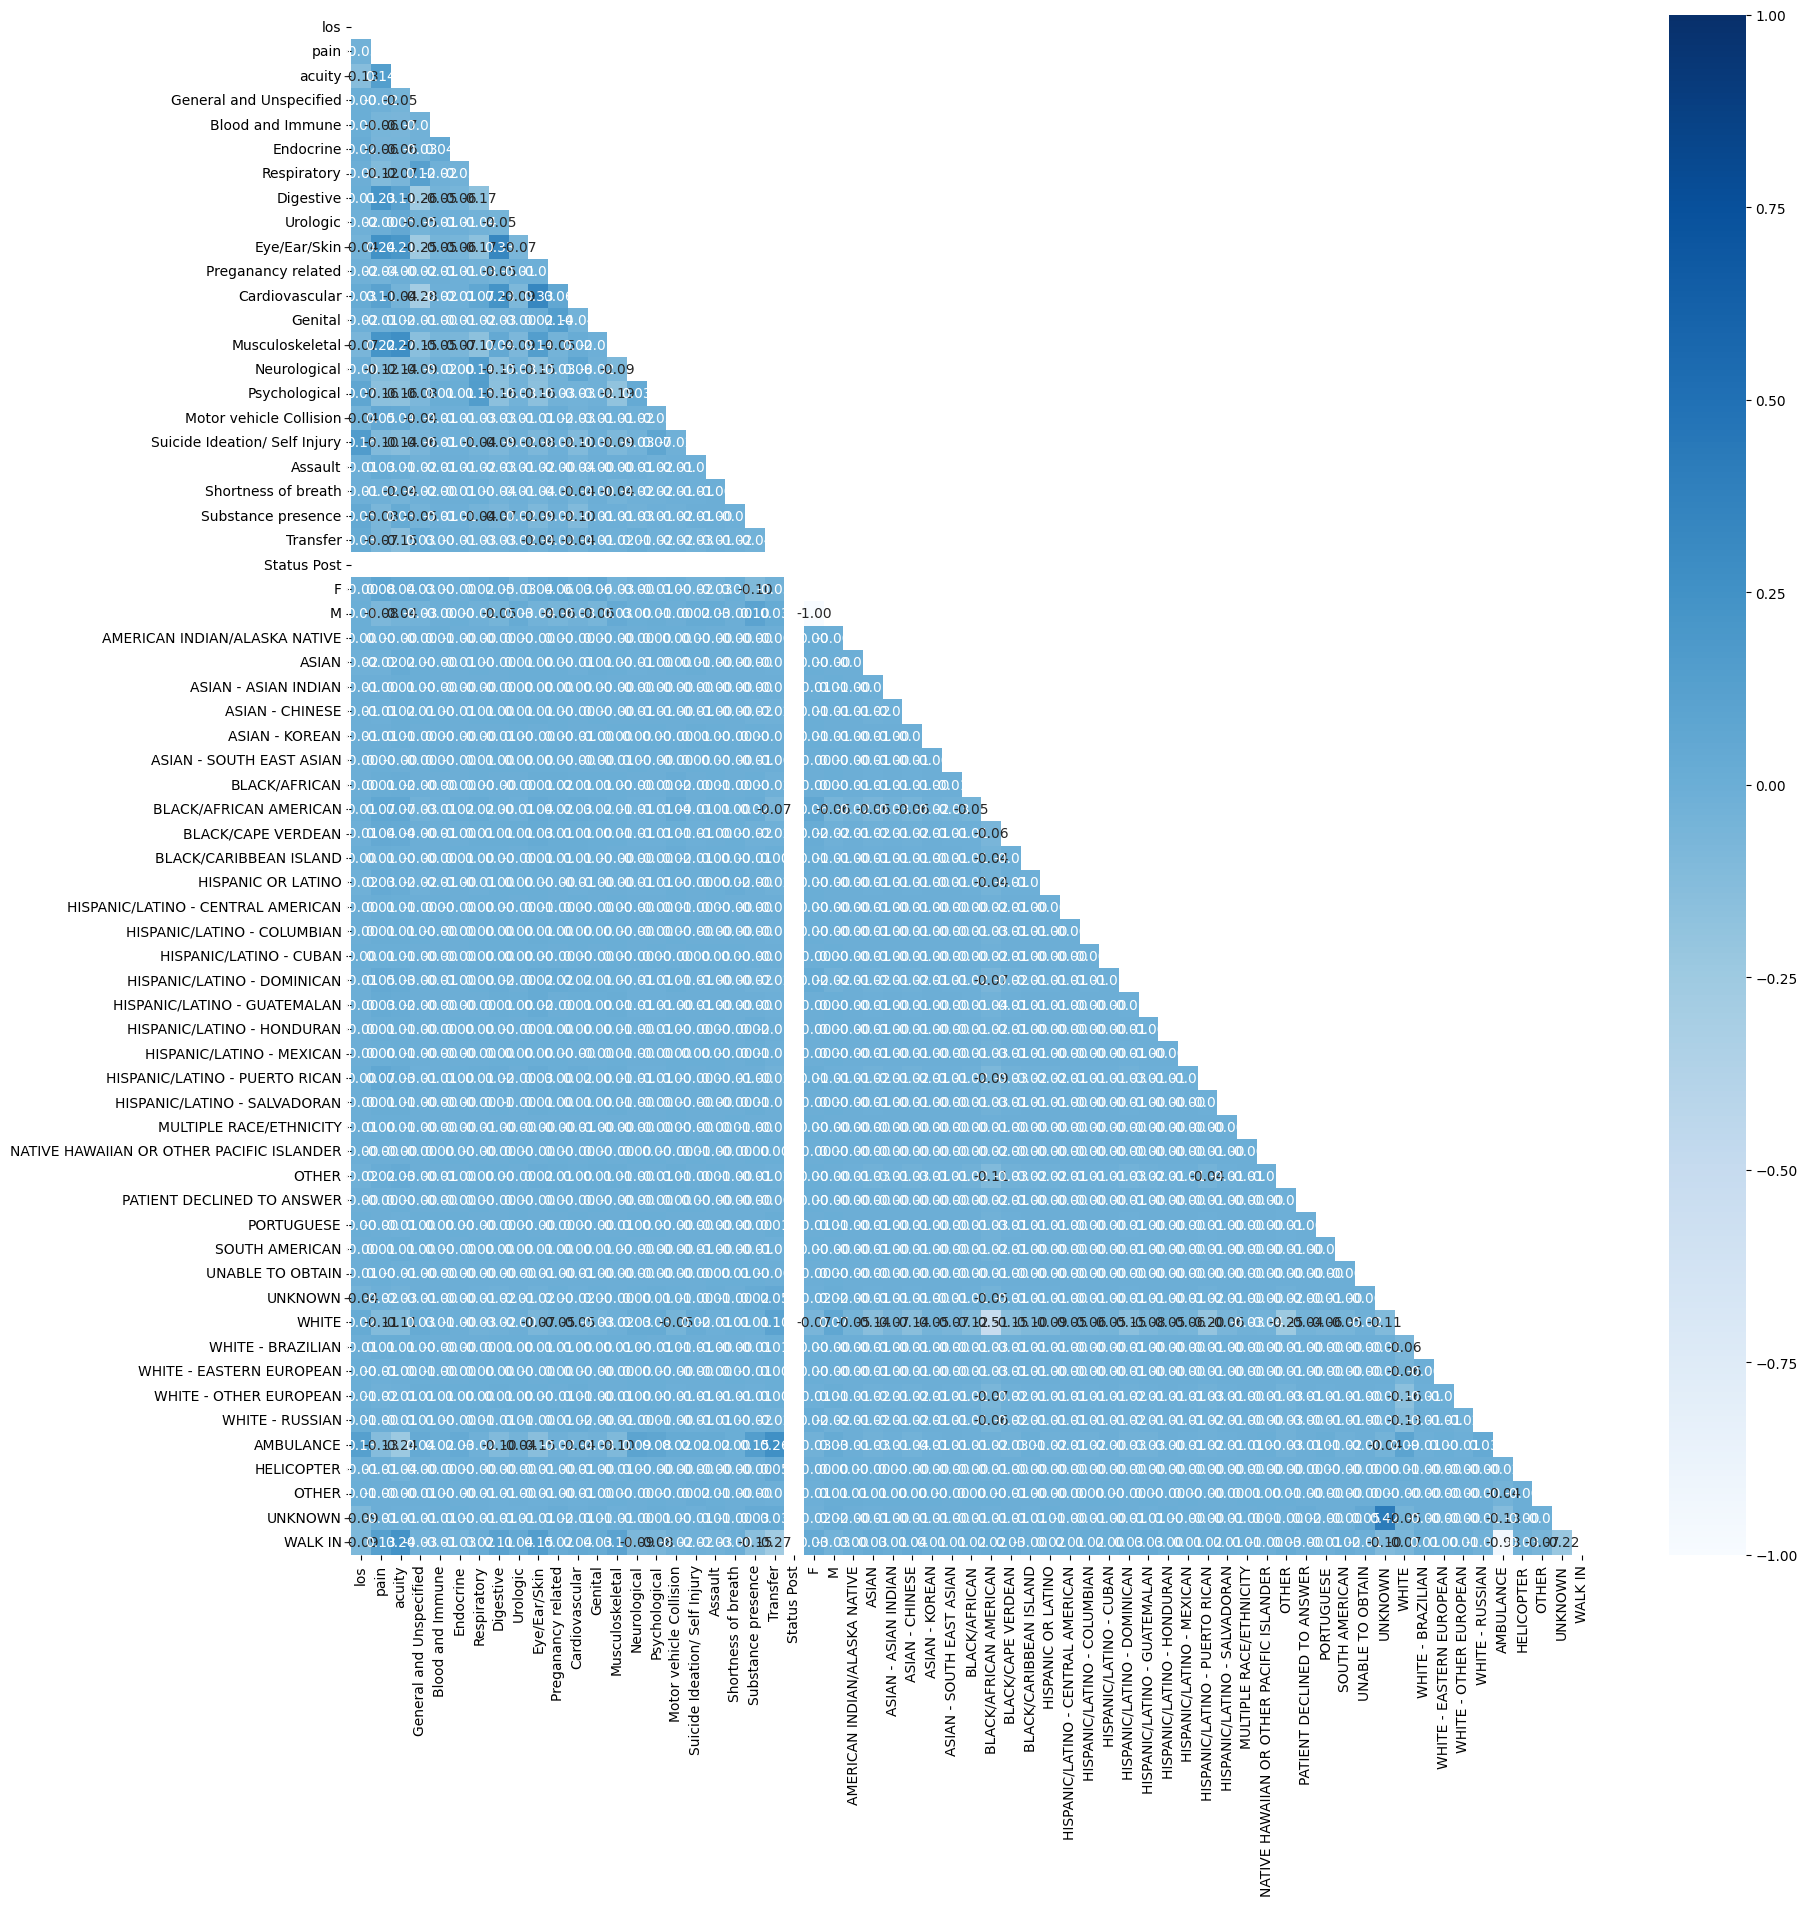

In [93]:
cor = df_los.iloc[:,1:].corr()
mask = np.triu(np.ones_like(cor, dtype=np.bool))
plt.figure(figsize=(20,20))
ax = sn.heatmap(cor, cmap='Blues', mask = mask, annot=True, fmt='.2f',vmin=-1, vmax=1)

In [94]:
col_list = cor.columns.to_list()
col_list = [i.replace(' ', '') for i in col_list]
col_list



['los',
 'pain',
 'acuity',
 'GeneralandUnspecified',
 'BloodandImmune',
 'Endocrine',
 'Respiratory',
 'Digestive',
 'Urologic',
 'Eye/Ear/Skin',
 'Preganancyrelated',
 'Cardiovascular',
 'Genital',
 'Musculoskeletal',
 'Neurological',
 'Psychological',
 'MotorvehicleCollision',
 'SuicideIdeation/SelfInjury',
 'Assault',
 'Shortnessofbreath',
 'Substancepresence',
 'Transfer',
 'StatusPost',
 'F',
 'M',
 'AMERICANINDIAN/ALASKANATIVE',
 'ASIAN',
 'ASIAN-ASIANINDIAN',
 'ASIAN-CHINESE',
 'ASIAN-KOREAN',
 'ASIAN-SOUTHEASTASIAN',
 'BLACK/AFRICAN',
 'BLACK/AFRICANAMERICAN',
 'BLACK/CAPEVERDEAN',
 'BLACK/CARIBBEANISLAND',
 'HISPANICORLATINO',
 'HISPANIC/LATINO-CENTRALAMERICAN',
 'HISPANIC/LATINO-COLUMBIAN',
 'HISPANIC/LATINO-CUBAN',
 'HISPANIC/LATINO-DOMINICAN',
 'HISPANIC/LATINO-GUATEMALAN',
 'HISPANIC/LATINO-HONDURAN',
 'HISPANIC/LATINO-MEXICAN',
 'HISPANIC/LATINO-PUERTORICAN',
 'HISPANIC/LATINO-SALVADORAN',
 'MULTIPLERACE/ETHNICITY',
 'NATIVEHAWAIIANOROTHERPACIFICISLANDER',
 'OTHER',
 'PA

In [95]:
cor.columns = col_list
cor_features = list(cor.iloc[0].round(2))
for i,cor in enumerate(cor_features):
  if abs(cor) > 0.049:
    print(col_list[i]+': '+str(cor))

los: 1.0
acuity: -0.13
Musculoskeletal: -0.07
Psychological: 0.07
SuicideIdeation/SelfInjury: 0.16
Substancepresence: 0.05
AMBULANCE: 0.13
UNKNOWN: -0.09
WALKIN: -0.09


### Extraction of Contextual Dynamic Features

#### number of patients treated at the event - Do not run this code block again if it was run once as it is. Extract the saved results.

The number of patients treated at the event is calculated by the number of patients who have arrived at ED before the event time stamp - number of patients discharged from the ED before the event time stamp

In [ ]:
df['timestamps'] = pd.to_datetime(df['timestamps'])

df_entry = df.loc[df['activity'] == 'Enter the ED'][['stay_id','timestamps']]
df_entry.columns = ['stay_id','enter_time']

df_discharge = df.loc[df['activity'] == 'Discharge from the ED'][['stay_id','timestamps']].drop_duplicates()
df_discharge.columns = ['stay_id','discharge_time']

df_ed = df_entry.merge(df_discharge, on = 'stay_id')
df_ed.head()

,stay_id,enter_time,discharge_time
0,30000012,2126-02-14 20:22:00,2126-02-15 01:59:00
1,30000017,2185-06-18 11:51:00,2185-06-18 15:53:00
2,30000038,2152-12-07 16:37:00,2152-12-07 19:55:00
3,30000039,2165-10-06 11:47:00,2165-10-06 20:18:00
4,30000055,2155-07-18 17:03:00,2155-07-18 21:12:00


In [ ]:
df_events = df[['stay_id','activity','timestamps']]
df_events['hour'] = df_events['timestamps'].dt.floor('H')
df_events['minute'] = df_events['timestamps'].dt.floor('1min')
df_events.head()

<ipython-input-85-cd41d920d47c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['hour'] = df_events['timestamps'].dt.floor('H')
<ipython-input-85-cd41d920d47c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['minute'] = df_events['timestamps'].dt.floor('1min')


,stay_id,activity,timestamps,hour,minute
0,30000012,Enter the ED,2126-02-14 20:22:00,2126-02-14 20:00:00,2126-02-14 20:22:00
1,30000012,Triage in the ED,2126-02-14 20:22:01,2126-02-14 20:00:00,2126-02-14 20:22:00
2,30000012,Medicine reconciliation,2126-02-14 22:21:00,2126-02-14 22:00:00,2126-02-14 22:21:00
3,30000012,Medicine reconciliation,2126-02-14 22:21:00,2126-02-14 22:00:00,2126-02-14 22:21:00
4,30000012,Medicine reconciliation,2126-02-14 22:21:00,2126-02-14 22:00:00,2126-02-14 22:21:00


In [ ]:
df_hour = df_events[['hour']].drop_duplicates()
df_minute = df_events[['minute']].drop_duplicates()

print(len(df_events))
print(len(df_hour))
print(len(df_minute))

7488243
734028
3408809


In [ ]:
#computation of crowdedness
df_hour['patient_count'] = df_hour.apply(lambda row: len(df_ed[(df_ed['enter_time'] <= row['hour']) & (df_ed['discharge_time'] > row['hour'])]), axis=1)
df_hour.head()


,hour,patient_count
0,2126-02-14 20:00:00,6
2,2126-02-14 22:00:00,6
11,2126-02-14 23:00:00,7
12,2126-02-15 00:00:00,7
19,2126-02-15 01:00:00,4


In [ ]:
df_events = df_events.merge(df_hour, on = 'hour')[['stay_id', 'activity', 'timestamps', 'hour', 'patient_count']].drop_duplicates()
df_events.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_event_level_patient_count.csv", index = False)

#### event transition

Transition of events and event durations

In [96]:
df_act = df[['stay_id','timestamps','activity']]
df_act['activity_index'] = df_act.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')
df_act.head(20)

<ipython-input-96-a17a6a739540>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act['activity_index'] = df_act.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')


,stay_id,timestamps,activity,activity_index
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,9.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,10.0


In [97]:
df_act['activity_index_next'] = df_act['activity_index']-1
df_loops = df_act.merge(df_act, left_on = ['stay_id','activity_index'],right_on =  ['stay_id','activity_index_next'], how = 'left')
df_loops.head()


<ipython-input-97-74ba02aa7c63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act['activity_index_next'] = df_act['activity_index']-1


,stay_id,timestamps_x,activity_x,activity_index_x,activity_index_next_x,timestamps_y,activity_y,activity_index_y,activity_index_next_y
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,0.0,2126-02-14 20:22:01,Triage in the ED,2.0,1.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,1.0,2126-02-14 22:21:00,Medicine reconciliation,3.0,2.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2.0,2126-02-14 22:21:00,Medicine reconciliation,4.0,3.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,3.0,2126-02-14 22:21:00,Medicine reconciliation,5.0,4.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,4.0,2126-02-14 22:21:00,Medicine reconciliation,6.0,5.0


In [98]:
df_loops = df_loops[['stay_id', 'timestamps_x', 'activity_x', 'activity_index_x',
       'timestamps_y', 'activity_y']]
df_loops.columns =  ['stay_id', 'timestamps', 'activity', 'activity_index','timestamps_next', 'activity_next'
       ]

In [99]:
df_loops['loop_len_min'] = round(( df_loops['timestamps_next'] -df_loops['timestamps']).dt.total_seconds() / 60,0)
df_loops.head()

,stay_id,timestamps,activity,activity_index,timestamps_next,activity_next,loop_len_min
0,30000012,2126-02-14 20:22:00,Enter the ED,1.0,2126-02-14 20:22:01,Triage in the ED,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,2.0,2126-02-14 22:21:00,Medicine reconciliation,119.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,2126-02-14 22:21:00,Medicine reconciliation,0.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,2126-02-14 22:21:00,Medicine reconciliation,0.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,2126-02-14 22:21:00,Medicine reconciliation,0.0


##### Outcomes

In [100]:
df_entry = df.loc[df['activity'] == 'Enter the ED'][['stay_id','timestamps']]
df_entry.columns = ['stay_id','enter_time']

df_discharge = df.loc[df['activity'] == 'Discharge from the ED'][['stay_id','timestamps','disposition']].drop_duplicates()
df_discharge.columns = ['stay_id','discharge_time','disposition']

#### Vital sign readings

In [116]:
df_vitals = df[['stay_id','timestamps','activity','temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp']].drop_duplicates()

df_vitals.ffill(inplace=True)

#resetting the enter the ED vitals values to NaN
cols = ['temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp']
for col in cols:
  df_vitals.loc[df_vitals['activity'] == 'Enter the ED',col] = np.nan

df_vitals.head(20)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0
11,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0
12,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0
13,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0
16,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0
18,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0
19,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0


###### Vital sign reading differences:

Context iinformation for vital sign readings
At the triage stage, we evaluate how different is the patient's vital signs compared to the established median for a healthy individual. We extract this context information from the domain relevant sources.



*   https://www.physio-pedia.com/Vital_Signs
*   https://meded.ucsd.edu/clinicalmed/vital.html



In [118]:
df_vitals_at_triage = df_vitals.loc[df_vitals['activity'] == 'Triage in the ED'][['stay_id','temperature', 'heartrate', 'resprate','o2sat', 'sbp', 'dbp']]

df_vitals_at_triage.columns = ['stay_id','temperature_triage', 'heartrate_triage', 'resprate_triage','o2sat_triage',	'sbp_triage','dbp_triage']

In [119]:
#difference of vital signs compared to the triage reading
row_diffs = df_vitals.merge(df_vitals_at_triage, on = 'stay_id')
for vital in ['temperature', 'heartrate', 'resprate','o2sat', 'sbp', 'dbp']:
  row_diffs[vital+'_diff'] = row_diffs[vital]-row_diffs[vital+'_triage']
  row_diffs = row_diffs.drop(columns = [vital,vital+'_triage'])


df_vitals = df_vitals.merge(row_diffs, on = ['stay_id','timestamps','activity'])
df_vitals.head(20)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp,temperature_diff,heartrate_diff,resprate_diff,o2sat_diff,sbp_diff,dbp_diff
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0,0.0,-16.0,-5.0,6.0,-48.0,-10.0
5,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,-16.0,-5.0,6.0,-48.0,-10.0
6,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,-16.0,-5.0,6.0,-48.0,-10.0
7,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0,0.0,-16.0,-5.0,6.0,-48.0,-10.0
8,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,-8.0,-2.0,7.0,-25.0,-3.0
9,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,-8.0,-2.0,7.0,-25.0,-3.0


In [120]:
#difference of vital signs compared to reference ranges
ref_diffs = df_vitals[['temperature', 'heartrate', 'resprate','o2sat', 'sbp', 'dbp']] - [98.6, 75, 15, 96,120,80]
ref_diffs.columns = ['temperature_ref_diff', 'heartrate_ref_diff', 'resprate_ref_diff','o2sat_ref_diff', 'sbp_ref_diff', 'dbp_ref_diff']
df_vitals = df_vitals.join(ref_diffs)

In [121]:

df_vitals.head(10)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp,temperature_diff,...,resprate_diff,o2sat_diff,sbp_diff,dbp_diff,temperature_ref_diff,heartrate_ref_diff,resprate_ref_diff,o2sat_ref_diff,sbp_ref_diff,dbp_ref_diff
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
4,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
5,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
6,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
7,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
8,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,...,-2.0,7.0,-25.0,-3.0,0.0,13.0,1.0,4.0,15.0,-29.0
9,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,...,-2.0,7.0,-25.0,-3.0,0.0,13.0,1.0,4.0,15.0,-29.0


#### Medicine dispensations

In [122]:
df_meds = df.loc[df['activity']=='Medicine dispensations'][['stay_id','activity','timestamps','name']]
df_meds = df_meds.groupby(['stay_id','activity','timestamps'])['name'].agg(', '.join).reset_index()
df_meds.head()

,stay_id,activity,timestamps,name
0,30000012,Medicine dispensations,2126-02-15 00:44:00,"Gabapentin, Spironolactone"
1,30000012,Medicine dispensations,2126-02-15 01:22:00,CefTRIAXone (Mini Bag Plus)
2,30000017,Medicine dispensations,2185-06-18 14:48:00,"Multivitamins, Multivitamins, Multivitamins, T..."
3,30000017,Medicine dispensations,2185-06-18 14:49:00,FoLIC Acid
4,30000038,Medicine dispensations,2152-12-07 18:31:00,CefTRIAXone 1gm/100mL 100mL Bag


In [123]:
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['/'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
#process the medicine name for identify which medication has been offered.

df_meds['name'] = df_meds['name'].astype(str)
# Remove punctuation
df_meds['name_processed'] = df_meds['name'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_meds['name_processed']  = df_meds['name_processed'] .map(lambda x: x.lower())

data = df_meds['name_processed'] .values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])


['gabapentin', 'spironolactone']


In [125]:
words = []
for sent in data_words:
  words.extend(sent)

from collections import Counter

word_counts = Counter(words)
# Get the 100 most common terms
most_common_terms = word_counts.most_common(100)

key_words = [term for term, count in most_common_terms]
key_words

['ml',
 'mg',
 'tab',
 'vial',
 'ondansetron',
 'acetaminophen',
 'morphine',
 'lorazepam',
 'bag',
 'neb',
 'sodium',
 'hydromorphone',
 'sulfate',
 'oxycodone',
 'syr',
 'lidocaine',
 'dilaudid',
 'magnesium',
 'ceftriaxone',
 'tetanus',
 'ketorolac',
 'ibuprofen',
 'fentanyl',
 'diphtox',
 'aspirin',
 'immediate',
 'albuterol',
 'sulfat',
 'vancomycin',
 'cap',
 'diazepam',
 'acellular',
 'pertuss',
 'soln',
 'chloride',
 'ipratropium',
 'aluminum',
 'potassium',
 'bromide',
 'gm',
 'release',
 'metoprolol',
 'prednisone',
 'pantoprazole',
 'gabapentin',
 'ciprofloxacin',
 'jelly',
 'udcup',
 'heparin',
 'azithromycin',
 'haloperidol',
 'readi',
 'cat',
 'barium',
 'vancomyci',
 'hydrox',
 'simet',
 'succ',
 'multivitamins',
 'rel',
 'mini',
 'mcg',
 'plus',
 'citrate',
 'furosemide',
 'propofol',
 'cefepime',
 'viscous',
 'diphenhydramine',
 'tartrate',
 'urojet',
 'thiamine',
 'metronidazole',
 'flagyl',
 'odt',
 'midazolam',
 'metoclopramide',
 'amp',
 'calcium',
 'cefazolin',
 '

In [127]:
#Keyword based dictionaries

#highlevel category
med_cat = {'Nausea and vomit prevension':['ondansetron','metoclopramide'],
'Fever reducer':['acetaminophen','aspirin'],
'Pain reliever':['morphine', 'hydromorphone', 'oxycodone', 'dilaudid', 'ibuprofen', 'fentanyl','nitroglycerin'],
'Sedative':['lorazepam','diazepam','midazolam'],
'Anti-biotic':['ceftriaxone', 'vancomycin', 'ciprofloxacin','azithromycin','vancomyci','cefepime','metronidazole','cefazolin','piperacillin',  'tazobactam', 'sulfameth','trimeth'],
'Anti-inflamatory':['ketorolac','prednisone','dexamethasone'],
'Airflow improver':['albuterol','ipratropium'],
'Cardio medication':['metoprolol','lisinopril'],
'Reflux reliever':['pantoprazole','omeprazole'],
'Nerve pain reliever':['gabapentin'],
'Blood thinner':['heparin'],
'Anti-psychotic':['haloperidol'],
'Multivitamin':['multivitamins'],
'General anesthetic':['propofol'],
'Antihistamin':['diphenhydramine'],
'Local anesthetic':['uroject'],
'IBS reliever':['donnatol']}


#special flags
med_method = {'Oral':['tab','odt','cap','syr'],
'Vial':['vial'],
'IV':['bag'],
'Nebulaize':['neb'],
'Solution':['soln']}

In [129]:
med_cat_labels = list(med_cat.keys())

med_method_labels = list(med_method.keys())

medication_category = {'medication_cat_Nausea and vomit prevension':[],
'medication_cat_Fever reducer':[],
'medication_cat_Pain reliever':[],
'medication_cat_Sedative':[],
'medication_cat_Anti-biotic':[],
'medication_cat_Anti-inflamatory':[],
'medication_cat_Airflow improver':[],
'medication_cat_Cardio medication':[],
'medication_cat_Reflux reliever':[],
'medication_cat_Nerve pain reliever':[],
'medication_cat_Blood thinner':[],
'medication_cat_Anti-psychotic':[],
'medication_cat_Multivitamin':[],
'medication_cat_General anesthetic':[],
'medication_cat_Antihistamin':[],
'medication_cat_Local anesthetic':[],
'medication_cat_IBS reliever':[]}
medication_method = {'med_method_Oral':[],
'med_method_Vial':[],
'med_method_IV':[],
'med_method_Nebulaize':[],
'med_method_Solution':[]}

for i,word in enumerate(data_words):
  set_med = set(word)

  cat_prob = 0.00000005
  final_category = 'Other'

  for cat in med_cat_labels:
    set_med_cat = set(med_cat[cat])
    n = intersection_size = len(set_med & set_med_cat)
    cat_prob = (n/(len(set_med)+1))
    medication_category['medication_cat_'+cat].append(cat_prob)


  method_prob = 0.00000005
  final_method = 'Other'

  for met in med_method_labels:
    set_med_met = set(med_method[met])
    n = intersection_size = len(set_med & set_med_met)
    method_prob = (n/(len(set_med)+1))
    medication_method['med_method_'+met].append(method_prob)




In [130]:
df_medication_category = pd.DataFrame(medication_category)
row_totals = df_medication_category.sum(axis=1)  # Calculate the row totals

# Divide each row by its respective row total
df_medication_category = df_medication_category.div(row_totals, axis=0)
df_medication_category = df_medication_category.fillna(0)
df_medication_category.head()

,medication_cat_Nausea and vomit prevension,medication_cat_Fever reducer,medication_cat_Pain reliever,medication_cat_Sedative,medication_cat_Anti-biotic,medication_cat_Anti-inflamatory,medication_cat_Airflow improver,medication_cat_Cardio medication,medication_cat_Reflux reliever,medication_cat_Nerve pain reliever,medication_cat_Blood thinner,medication_cat_Anti-psychotic,medication_cat_Multivitamin,medication_cat_General anesthetic,medication_cat_Antihistamin,medication_cat_Local anesthetic,medication_cat_IBS reliever
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
df_medication_method = pd.DataFrame(medication_method)
row_totals = df_medication_method.sum(axis=1)  # Calculate the row totals

# Divide each row by its respective row total
df_medication_method = df_medication_method.div(row_totals, axis=0)
df_medication_method = df_medication_method.fillna(0)
df_medication_method.head()

,med_method_Oral,med_method_Vial,med_method_IV,med_method_Nebulaize,med_method_Solution
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [132]:
df_t = df_medication_category.join(df_medication_method)
df_t.sum()

medication_cat_Nausea and vomit prevension     62990.033333
medication_cat_Fever reducer                   98802.159524
medication_cat_Pain reliever                  178550.142857
medication_cat_Sedative                        51369.766667
medication_cat_Anti-biotic                     71385.380952
medication_cat_Anti-inflamatory                28807.059524
medication_cat_Airflow improver                25371.250000
medication_cat_Cardio medication               15392.219048
medication_cat_Reflux reliever                 13173.919048
medication_cat_Nerve pain reliever             10300.669048
medication_cat_Blood thinner                    7095.416667
medication_cat_Anti-psychotic                   5765.900000
medication_cat_Multivitamin                     3454.633333
medication_cat_General anesthetic               4793.250000
medication_cat_Antihistamin                     8088.483333
medication_cat_Local anesthetic                    0.000000
medication_cat_IBS reliever             

In [133]:
df_meds = df_meds.join(df_t)

In [135]:
df_meds = df_meds.drop(columns ='name_processed')

### Construction of Full Event Log for Prediction

In [136]:
df.columns

Index(['stay_id', 'subject_id', 'hadm_id', 'timestamps', 'activity', 'gender',
       'race', 'arrival_transport', 'disposition', 'seq_num', 'icd_code',
       'icd_version', 'icd_title', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'rhythm',
       'name', 'gsn', 'ndc', 'etc_rn', 'etccode', 'etcdescription', 'med_rn',
       'gsn_rn', 'los', 'hour'],
      dtype='object')

In [137]:
df_mimicel_pred = df[['stay_id','timestamps', 'activity']]
df_mimicel_pred ['activity_index'] = df_mimicel_pred.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')-1

df_loops['transition'] = df_loops['activity']+'->'+df_loops['activity_next']

df_mimicel_pred.head(10)

<ipython-input-137-ed41b5754d6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mimicel_pred ['activity_index'] = df_mimicel_pred.groupby('stay_id')['timestamps'].rank(ascending=True, method = 'first')-1


,stay_id,timestamps,activity,activity_index
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0


In [138]:
df_mimicel_pred = df_mimicel_pred.merge(df_loops[['stay_id','transition','loop_len_min','activity_index']], on = ['stay_id','activity_index'], how = 'left')
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0


In [139]:
df_mimicel_pred = df_mimicel_pred.merge(df_entry, on =  'stay_id')
df_mimicel_pred = df_mimicel_pred.merge(df_discharge, on =  'stay_id')

In [140]:
df_mimicel_pred['los_min'] = round(( df_mimicel_pred['discharge_time'] -df_mimicel_pred['enter_time']).dt.total_seconds() / 60,0)
df_mimicel_pred['time_elapsed_min'] = round(( df_mimicel_pred['timestamps'] -df_mimicel_pred['enter_time']).dt.total_seconds() / 60,0)
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,time_elapsed_min
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,NaN,NaN,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,119.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,120.0


In [141]:
df_vitals.head(10)

,stay_id,timestamps,activity,temperature,heartrate,resprate,o2sat,sbp,dbp,temperature_diff,...,resprate_diff,o2sat_diff,sbp_diff,dbp_diff,temperature_ref_diff,heartrate_ref_diff,resprate_ref_diff,o2sat_ref_diff,sbp_ref_diff,dbp_ref_diff
0,30000012,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,2126-02-14 20:22:01,Triage in the ED,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
3,30000012,2126-02-14 22:22:00,Medicine reconciliation,98.8,96.0,18.0,93.0,160.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.2,21.0,3.0,-3.0,40.0,-26.0
4,30000012,2126-02-14 23:43:00,Vital sign check,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
5,30000012,2126-02-15 00:16:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
6,30000012,2126-02-15 00:17:00,Medicine reconciliation,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
7,30000012,2126-02-15 00:44:00,Medicine dispensations,98.8,80.0,13.0,99.0,112.0,44.0,0.0,...,-5.0,6.0,-48.0,-10.0,0.2,5.0,-2.0,3.0,-8.0,-36.0
8,30000012,2126-02-15 00:50:00,Vital sign check,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,...,-2.0,7.0,-25.0,-3.0,0.0,13.0,1.0,4.0,15.0,-29.0
9,30000012,2126-02-15 01:22:00,Medicine dispensations,98.6,88.0,16.0,100.0,135.0,51.0,-0.2,...,-2.0,7.0,-25.0,-3.0,0.0,13.0,1.0,4.0,15.0,-29.0


In [142]:
df_mimicel_pred = df_mimicel_pred.merge(df_vitals, on = ['stay_id','activity','timestamps'])
df_mimicel_pred = df_mimicel_pred.merge(df_meds, on = ['stay_id','activity','timestamps'], how = 'left')


In [144]:
df_mimicel_pred = df_mimicel_pred.fillna(0)
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,medication_cat_Multivitamin,medication_cat_General anesthetic,medication_cat_Antihistamin,medication_cat_Local anesthetic,medication_cat_IBS reliever,med_method_Oral,med_method_Vial,med_method_IV,med_method_Nebulaize,med_method_Solution
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,0,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
df_static = pd.read_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_static.csv")
df_static.head()

,stay_id,gender,race,arrival_transport,pain,acuity,chiefcomplaint,chiefcomplaint_processed,General and Unspecified,Blood and Immune,...,Musculoskeletal,Neurological,Psychological,Motor vehicle Collision,Suicide Ideation/ Self Injury,Assault,Shortness of breath,Substance presence,Transfer,Status Post
0,30000012,F,WHITE,AMBULANCE,0.0,2.0,CHANGE IN MENTAL STATUS,change in mental status,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000017,M,BLACK/AFRICAN AMERICAN,WALK IN,0.0,3.0,"ETOH, Unable to ambulate",etoh unable to ambulate,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,30000038,F,WHITE,AMBULANCE,0.0,3.0,Cough,cough,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000039,M,WHITE,WALK IN,0.0,3.0,s/p Fall,s/p fall,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000055,F,OTHER,WALK IN,0.0,3.0,L Ear pain,l ear pain,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
df_static.columns

Index(['stay_id', 'gender', 'race', 'arrival_transport', 'pain', 'acuity',
       'chiefcomplaint', 'chiefcomplaint_processed', 'General and Unspecified',
       'Blood and Immune', 'Endocrine', 'Respiratory', 'Digestive', 'Urologic',
       'Eye/Ear/Skin', 'Preganancy related', 'Cardiovascular', 'Genital',
       'Musculoskeletal', 'Neurological', 'Psychological',
       'Motor vehicle Collision', 'Suicide Ideation/ Self Injury', 'Assault',
       'Shortness of breath', 'Substance presence', 'Transfer', 'Status Post'],
      dtype='object')

In [147]:
df_mimicel_pred = df_mimicel_pred.merge(df_static, on = ['stay_id'])
df_mimicel_pred.head(10)

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,Musculoskeletal,Neurological,Psychological,Motor vehicle Collision,Suicide Ideation/ Self Injury,Assault,Shortness of breath,Substance presence,Transfer,Status Post
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,0,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,30000012,2126-02-14 22:21:00,Medicine reconciliation,5.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,30000012,2126-02-14 22:21:00,Medicine reconciliation,6.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30000012,2126-02-14 22:21:00,Medicine reconciliation,7.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,30000012,2126-02-14 22:21:00,Medicine reconciliation,8.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,30000012,2126-02-14 22:22:00,Medicine reconciliation,9.0,Medicine reconciliation->Medicine reconciliation,1.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
df_patients = pd.read_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_event_level_patient_count.csv")
df_patients.head()

,stay_id,activity,timestamps,hour,patient_count
0,30000012,Enter the ED,2126-02-14 20:22:00,2126-02-14 20:00:00,6
1,30000012,Triage in the ED,2126-02-14 20:22:01,2126-02-14 20:00:00,6
2,36204753,Enter the ED,2126-02-14 20:01:00,2126-02-14 20:00:00,6
3,36204753,Triage in the ED,2126-02-14 20:01:01,2126-02-14 20:00:00,6
4,36204753,Vital sign check,2126-02-14 20:17:00,2126-02-14 20:00:00,6


In [149]:
df_patients= df_patients.drop_duplicates()
df_patients['timestamps'] = pd.to_datetime(df_patients['timestamps'])

df_mimicel_pred = df_mimicel_pred.merge(df_patients, on = ['stay_id', 'activity', 'timestamps'])
df_mimicel_pred.head()

,stay_id,timestamps,activity,activity_index,transition,loop_len_min,enter_time,discharge_time,disposition,los_min,...,Psychological,Motor vehicle Collision,Suicide Ideation/ Self Injury,Assault,Shortness of breath,Substance presence,Transfer,Status Post,hour,patient_count
0,30000012,2126-02-14 20:22:00,Enter the ED,0.0,0,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2126-02-14 20:00:00,6
1,30000012,2126-02-14 20:22:01,Triage in the ED,1.0,Enter the ED->Triage in the ED,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2126-02-14 20:00:00,6
2,30000012,2126-02-14 22:21:00,Medicine reconciliation,2.0,Triage in the ED->Medicine reconciliation,119.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2126-02-14 22:00:00,6
3,30000012,2126-02-14 22:21:00,Medicine reconciliation,3.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2126-02-14 22:00:00,6
4,30000012,2126-02-14 22:21:00,Medicine reconciliation,4.0,Medicine reconciliation->Medicine reconciliation,0.0,2126-02-14 20:22:00,2126-02-15 01:59:00,ADMITTED,337.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2126-02-14 22:00:00,6


In [150]:
df_mimicel_pred.isna().sum()

stay_id               0
timestamps            0
activity              0
activity_index        0
transition            0
                     ..
Substance presence    0
Transfer              0
Status Post           0
hour                  0
patient_count         0
Length: 81, dtype: int64

In [151]:
df_mimicel_pred.to_csv(my_dir+"/MIMICEL_PREPROCESSING/mimicel_pred_v2.csv", index = False)